# board_detection

- Detecting aruco checker board in input RGB images

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10.0, 10.0)
aruco = cv2.aruco

parameters = aruco.DetectorParameters_create()
dictionaryID = aruco.DICT_5X5_100
dictionary = aruco.getPredefinedDictionary(dictionaryID)

input_image_dirpath = os.path.join(os.getcwd(), "../pictures/sample/")
input_image_format = "*"

detection_result_dirname = "detection_result"

# Paremeters needed for board detection.
parameters = aruco.DetectorParameters_create()
board_config_filepath = \
    os.path.join(os.getcwd(), '../board/sample_board.csv')
df_board_configs = pd.read_csv(board_config_filepath, index_col=0)
dictionaryID = int(df_board_configs.loc['dict_ID']) # 5: aruco.DICT_5X5_100
dictionary = aruco.getPredefinedDictionary(dictionaryID)
squareL = float(df_board_configs.loc['square_length'])
markerL = float(df_board_configs.loc['marker_length'])
pixels_per_mm = 10 # for checker board image
A4size = (210, 297)
# minimum margin (height, width) when printing in mm
tb = int(df_board_configs.loc['margin_tb'])
tb = int(df_board_configs.loc['margin_lr'])
# unit: mm
squareNumX = int(df_board_configs.loc['num_squares_x'])
squareNumY = int(df_board_configs.loc['num_squares_y'])
boardSizeX = int(df_board_configs.loc['board_size_x'])
boardSizeY = int(df_board_configs.loc['board_size_y'])

In [2]:
def get_file_paths(file_dirpath, file_ext):
    path = os.path.join(file_dirpath, '*.'+file_ext)
    file_names = [os.path.basename(r) for r in glob.glob(path)]
    file_paths = [os.path.join(file_dirpath, fs) \
                    for fs in file_names]
    print(file_names)
    return file_paths, file_names


def imshow_inline(img_path="", img=None):
    if img is None:
        if not img_path:
            print("Give imshow_inline an image path or an image data.")
            return -1
        else:
            img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [3]:
def get_board_image():
    board = aruco.CharucoBoard_create(squareNumX, 
                                      squareNumY, 
                                      squareL, 
                                      markerL, 
                                      dictionary)
    
    # The third parameter is the (optional) margin in pixels, 
    # so none of the markers are touching the image border.
    # Finally, the size of the marker border, similarly to drawMarker() function. 
    # The default value is 1.
    boardImage = board.draw((boardSizeX*pixels_per_mm, 
                             boardSizeY*pixels_per_mm), 
                             None, 0, 1) # 10 pixels/mm
    return(board, boardImage)

In [4]:
def detect_ChArUco_board(image_paths, outimg=True):
    board, boardImg = get_board_image()

    for image_path in image_paths:
        checkerBoardImage = cv2.imread(image_path)
        if checkerBoardImage is None:
            print(os.path.basename(image_path)+" cannot be read.")
            continue

        # detect ChArUco markers
        markerCorners, markerIds  = [0,0]
        markerCorners, markerIds, rejectedImgPoints = \
            aruco.detectMarkers(checkerBoardImage, dictionary)

        # detect the checker board based on the detected marker
        outputImage = checkerBoardImage.copy()
        if markerIds is None:
            continue
        if markerIds.size > 0:
            charucoCorners, charucoIds = [0, 0]
            cv2.aruco.drawDetectedMarkers(outputImage, 
                                          markerCorners, 
                                          markerIds)

            res, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(
               markerCorners, markerIds, checkerBoardImage, board)
            outputImage = aruco.drawDetectedCornersCharuco(
               outputImage, charucoCorners, charucoIds)

        image_dirpath, image_filename = os.path.split(image_path)
        result_dirpath = os.path.join(image_dirpath, 
                                      detection_result_dirname)
        if not os.path.isdir(result_dirpath):
            os.mkdir(result_dirpath)
        imshow_inline(img=outputImage)
        if outimg:
            cv2.imwrite(os.path.join(result_dirpath, image_filename), 
                        outputImage)

['sample.bmp']


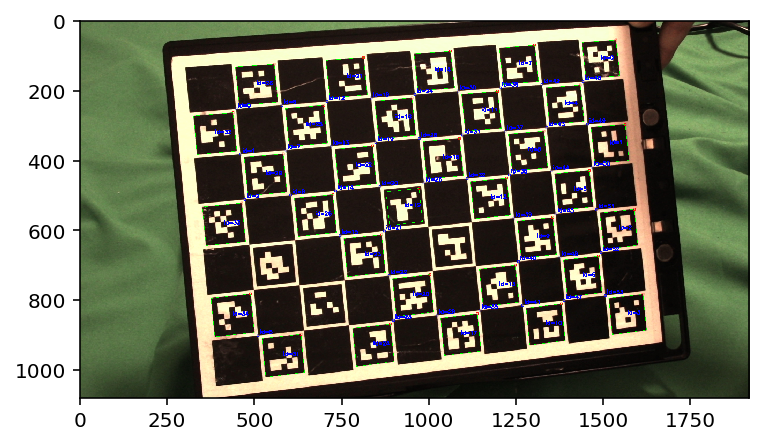

In [5]:
if __name__ == '__main__':
    picture_paths, picture_names = \
        get_file_paths(input_image_dirpath, 
                       input_image_format)
    detect_ChArUco_board(picture_paths)